In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Game generation

In [3]:
np.random.seed(99999)

In [4]:
def new_game(k=3,min_value=3,max_value=15):
    game_board = np.zeros((k,k))
    constraints = np.zeros((2,k))
    solution = "" #This is hidden in the code (only used for debugging)
    for i in range(k):
        for j in range(k):
            game_board[i][j] = np.random.randint(min_value,max_value+1)
            #Randomly delete 1/3 of the cells from sum
            if np.random.randint(0,3) > 0:
                constraints[0][i]+=game_board[i][j] #horizontal sum
                constraints[1][j]+=game_board[i][j] #vertical sum  
                solution += "1"
                continue
            solution += "0"
            
    return game_board, constraints, solution
        

In [5]:
# K=15

In [6]:
# game_board,constraints,solution = new_game(k=K)
# game_board,constraints,solution

## 1. Population Initialisation

In [7]:
def intialise_population(pop_size,k):
    generation_0 = []
    for pp in range(pop_size):
        population = ""
        for i in range(k):
            for j in range(k):
                population+=str(np.random.randint(0,2))
        generation_0.append(population)
    return np.array(generation_0)

In [8]:
# initial_population = intialise_population(50,k=K)
# initial_population

## 2. Fitness

In [13]:
NAIVE = False

In [14]:
def get_fitness(candidate, game_board, constraints):
    k = int(np.sqrt(len(candidate)))
    candidate_array = np.array(list(candidate), dtype=int).reshape((k, k))

    row_sums = np.sum(game_board * candidate_array, axis=1)
    col_sums = np.sum(game_board * candidate_array, axis=0)

    if not NAIVE:
        total = np.sum(row_sums == constraints[0]) + np.sum(col_sums == constraints[1])
        return total

    # The naive approach is to return 0 or 1 to indicate if the population is a candidate or not
    return 1 if (row_sums == constraints[0]).all() and (col_sums == constraints[1]).all() else 0


In [15]:
# for i in initial_population:
#     print(solution,i,get_fitness(i,game_board, constraints))

## 3. Ranking & Selection

In [16]:
def rank(population):
    ranking = []
    for i in range(len(population)):
        ranking.append((np.sum(get_fitness(population[i],game_board,constraints)),i))
    return np.array(sorted(ranking,reverse=True))

In [17]:
# ranking = rank(initial_population)
# for r in ranking:
#     print(initial_population[r[1]],r[0])

In [18]:
def selection(ranked, elitism):
    n = len(ranked)
    probabilities = np.zeros(n)
    members = np.arange(n)
    elite_members = []
    
    for i in range(n):
        if i < elitism:
            elite_members.append(ranked[i][1])
        probabilities[ranked[i][1]] = ranked[i][0]
    
    if not NAIVE:
        # Check if the sum of probabilities is not zero before normalization
        sum_probabilities = np.sum(probabilities)
        if sum_probabilities != 0:
            probabilities = probabilities / sum_probabilities
        else:
            # If sum of probabilities is zero, assign equal probabilities to all members
            probabilities = np.ones_like(probabilities) / n
    else:
        #assign equal probability to all members of the population (because sum_of_fitness=0)
        probabilities = np.ones_like(probabilities) / n
    
    # Select whether to add an individual from the remaining n-elitism members using their weighted probabilities
    selected_members = np.random.choice(members, n - elitism, p=probabilities)
    
    return selected_members, np.array(elite_members)        

In [19]:
# selected,elite = selection(ranking,10)
# selected,elite

In [20]:
def mating_pool(population, selected_members, elite_members):
    pool = np.array([population[x] for x in selected_members])
    elite = np.array([population[x] for x in elite_members])
    return pool, elite

In [21]:
# pool, elite_pool = mating_pool(initial_population,selected,elite)
# pool, elite_pool 

## 4. Breeding

In [22]:
def breeding(k,parent1,parent2):
    
    geneA = np.random.randint(0,k-1)
    geneB = np.random.randint(1,k)
    
    while geneA >= geneB:
        geneA = np.random.randint(0,k-1)
        geneB = np.random.randint(1,k)
    child = ""
    for i in range(k):
        for j in range(k):
            if i>=geneA and i<=geneB:
                child += parent1[i*k+j]
            else:
                child += parent2[i*k+j]
    #print(f"P1:{parent1} & P2:{parent2} => {child}")
    return child

In [23]:
def new_population(k,mating_pool,elite_pool):
    children = [elite for elite in elite_pool]
    n = len(mating_pool)
    # Sample from the mating pool with replacement to create a pool of mating parents
    pool_indices = np.random.choice(np.arange(n), n)
    pool = [mating_pool[i] for i in pool_indices]
    
    for i in range(n):
        child = breeding(k,pool[i],pool[n-i-1])
        children.append(child)
    return np.array(children)

In [24]:
# new_population(K,pool,elite_pool)

## 5. Mutate

In [77]:
def mutate(chromosome):
    k = int(np.sqrt(len(chromosome))) #kxk grid
    to_modify = int(np.sqrt(k)) 
    #we are modifying sqrt(k) rows
    for _ in range(to_modify):
        #Choose which row we are modifying at random
        i = np.random.randint(0,k-1)
        #Resample the values for that random row at random
        i *= k #Staring position of i^th row in the chromosome
        for column in range(k):
            if chromosome[i] == '1':
                chromosome = chromosome[:i] + '0' + chromosome[i + 1:]
            else:
                chromosome = chromosome[:i] + '1' + chromosome[i + 1:]
            i += 1
    return chromosome
def mutate_population(population, prob_mut):
    mutated_population = []
    for individual in population:
        if np.random.rand() <= prob_mut:
            mutated_population.append(mutate(individual))
        else:
            mutated_population.append(individual)
    return mutated_population

## 6. New Generation

In [78]:
def new_generation(k,current_gen, elitism, prob_mut):
    ranking = rank(current_gen)
    selected,elite = selection(ranking,elitism)
    pool, elite_pool = mating_pool(current_gen,selected,elite)
    children = new_population(k,pool,elite_pool)
    next_gen = mutate_population(children, prob_mut)
    return next_gen

## 7. Genetic Algorithm

In [79]:
def genetic_algorithm(pop_size, elitism, prob_mut, generations, k, verbose=False, NoG=300):
    pop = intialise_population(pop_size,k)
    ranked = rank(pop)
    x_0 = ranked[0][0]
    x_1 = -1
    ys = [x_0]
        
    stucked=0
    for i in range(generations):
        pop = new_generation(k,pop, elitism, prob_mut)
        ranked = rank(pop)
        if ranked[0][0] <= x_1:
            stucked += 1
        else:
            stucked = 0
        x_1 = max(x_1,ranked[0][0])
        ys.append(x_1)
        if not NAIVE:
            if ranked[0][0]==2*k or stucked>=NoG:
                break
        if NAIVE:
            if ranked[0][0]==1 or stucked>=NoG:
                break
    #Plotting performance graph
    plt.plot([x for x in range(i+2)],ys)
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Score')
    plt.show()
    
    #for r in ranked:
    #    print(solution,pop[r[1]],r[0])

    return x_0,x_1,i

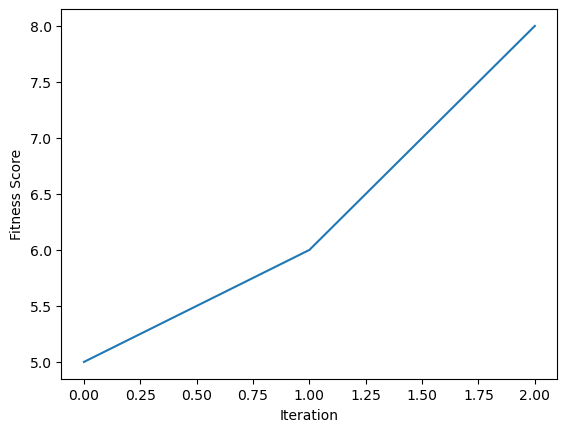

Initial fit: 5, Final Fit: 8, Found in generation: 1


In [80]:
K=4
game_board,constraints,solution = new_game(k=K)
x0,x1,i = genetic_algorithm(1000,50,0.08,1000,K,verbose=True)
print(f"Initial fit: {x0}, Final Fit: {x1}, Found in generation: {i}")

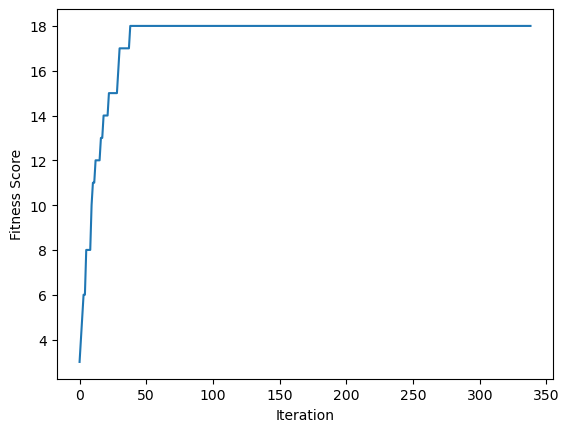

3 => 18/30 in 337 gerations


In [82]:
K = 15

game_board,constraints,_ = new_game(k=K)
x_0,x_1,it = genetic_algorithm(1000,50,0.08,1000,K,verbose=True)
print(f"{x_0} => {x_1}/{K*2} in {it} gerations")

In [101]:
ys_initial = []
ys_final = []
iterations = []
for i in y:
    ys_initial.append(i[0])
    ys_final.append(i[1])

for i in its:
    iterations.append(i*10)

In [102]:
print(ys_initial)
print(ys_final)
print(iterations)

[50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[100.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 195.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0, 600.0]


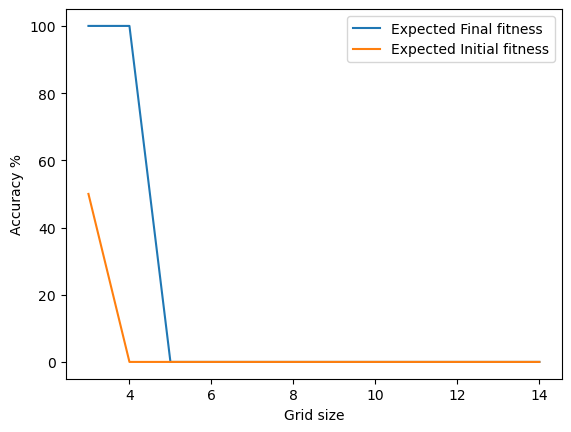

In [103]:
plt.plot(K,ys_final,label='Expected Final fitness')
plt.plot(K,ys_initial,label='Expected Initial fitness')

plt.legend()
plt.xlabel('Grid size')
plt.ylabel('Accuracy %')
plt.show()

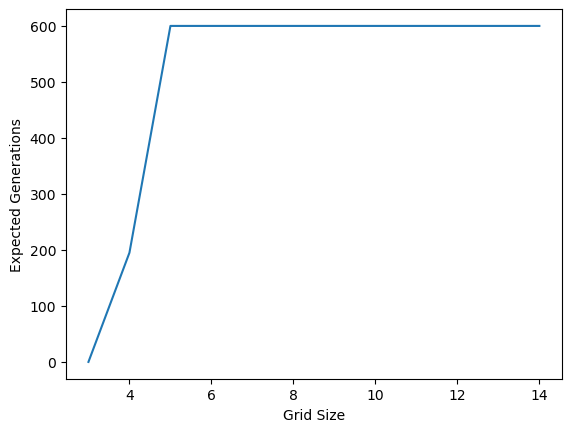

In [104]:
plt.plot(K,iterations)

plt.xlabel('Grid Size')
plt.ylabel('Expected Generations')
plt.show()